<a href="https://colab.research.google.com/github/javier-jaime/Stock_Price_Forecasting/blob/main/Update4_BTC_Price_Forecasting_with_yfinance_and_Facebook_Prophet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Bitcoin Price Forecasting with yfinance and Facebook Prophet**

## Importing all the necessary Libraries

In [1]:
!pip install yfinance
import yfinance as yf
import pandas as pd
import numpy as np
import plotly.express as px
from fbprophet import Prophet
import plotly.io as pio
pio.renderers.default='colab'

     |████████████████████████████████| 6.3 MB 8.2 MB/s 
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


## Importing the Dataset & Exploring it

In [39]:
# Stock Ticker Input
stock = input('Enter the stock ticker: ')
print(f'You entered {stock}, here is the data from the last 10 days:')
period = '3y'
ticker = yf.Ticker(stock)
data = ticker.history(period)
data.reset_index(inplace=True)
data.tail(10)

Enter the stock ticker: BTC-USD
You entered BTC-USD, here is the data from the last 10 days:


,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
1083,2021-12-01,56907.964844,59041.683594,56553.082031,57229.828125,36858195307,0,0
1084,2021-12-02,57217.371094,57349.234375,55895.132812,56477.816406,32379968686,0,0
1085,2021-12-03,56509.164062,57482.167969,52496.585938,53598.246094,39789134215,0,0
1086,2021-12-04,53727.878906,53904.679688,42874.617188,49200.703125,61385677469,0,0
1087,2021-12-05,49201.519531,49768.148438,47857.496094,49368.847656,37198201161,0,0
1088,2021-12-06,49413.480469,50929.519531,47281.035156,50582.625000,37707308001,0,0
1089,2021-12-07,50581.828125,51934.781250,50175.808594,50700.085938,33676814852,0,0
1090,2021-12-08,50667.648438,51171.375000,48765.988281,50504.796875,28479699446,0,0
1091,2021-12-09,50450.082031,50797.164062,47358.351562,47672.121094,29603577251,0,0
1092,2021-12-10,47597.632812,49899.292969,47597.632812,48451.398438,30637821952,0,0


In [40]:
print('These are the basic stats:')
data.describe()

These are the basic stats:


,Open,High,Low,Close,Volume,Dividends,Stock Splits
count,1093.000000,1093.000000,1093.000000,1093.000000,1.093000e+03,1093.0,1093.0
mean,21104.162459,21675.922721,20481.075304,21141.213113,3.149168e+10,0.0,0.0
std,18964.914691,19496.729102,18339.606926,18970.201073,2.082760e+10,0.0,0.0
min,3236.274658,3275.377930,3191.303467,3236.761719,3.551764e+09,0.0,0.0
25%,7997.807129,8177.793457,7824.448730,8000.329590,1.785192e+10,0.0,0.0
50%,10346.748047,10512.328125,10126.299805,10347.712891,2.791964e+10,0.0,0.0
75%,36050.113281,37755.890625,34659.589844,36178.140625,4.009966e+10,0.0,0.0
max,67549.734375,68789.625000,66382.062500,67566.828125,3.509679e+11,0.0,0.0


# Data Visualization (plotly express) - Visualizing the historical performance

In [41]:
#Line graph (Price), Area graph (Volume) , box plot (Analyzing price and volume)

In [42]:
px.line(data, x="Date", y="Close", title=f'{stock} Stock Close Price')

In [43]:
px.bar(data, x="Date", y="Volume", title=f'{stock} Stock Volume')

In [44]:
px.box(data, y="Close", title=f'{stock} box plot', height=500, width=500)

In [45]:
def get_hurst_exponent(time_series, max_lag=100):
    """Returns the Hurst Exponent of the time series"""
    lags = range(2, max_lag)
    # variances of the lagged differences
    tau = [np.std(np.subtract(time_series[lag:], time_series[:-lag])) for lag in lags]
    # calculate the slope of the log plot -> the Hurst Exponent
    reg = np.polyfit(np.log(lags), np.log(tau), 1)
    return reg[0]

In [55]:
hurst = pd.DataFrame(columns =["hurst_exp","lag"])
lags = range(4, 121, 2)
for lag in lags:
    hurst_exp = get_hurst_exponent(data["Close"].values, lag)
    hurst = hurst.append({"hurst_exp":hurst_exp,"lag":lag},ignore_index=True)
px.line(hurst, x="hurst_exp", y="lag", title=f'{stock} Hurst Exp')

## Data Preparation for Facebook Prophet

In [47]:
columns=['Date','Close']
prophet_df=pd.DataFrame(data,columns=columns)
prophet_df= prophet_df.rename(columns={'Date':'ds','Close':'y'})  
prophet_df.tail()

,ds,y
1088,2021-12-06,50582.625000
1089,2021-12-07,50700.085938
1090,2021-12-08,50504.796875
1091,2021-12-09,47672.121094
1092,2021-12-10,48451.398438


## Creating Facebook Prophet Model

In [48]:
m=Prophet(daily_seasonality=False)
m.fit(prophet_df)

##Forecasting

In [49]:
periods = 30
future=m.make_future_dataframe(periods)

In [50]:
forecast=m.predict(future)

In [51]:
forecast.head(10)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2018-12-10,-378.780303,-8634.996033,2254.891962,-378.780303,-378.780303,-2775.858358,-2775.858358,-2775.858358,65.528849,65.528849,65.528849,-2841.387207,-2841.387207,-2841.387207,0.0,0.0,0.0,-3154.638661
1,2018-12-11,-373.433377,-8138.796568,2580.086093,-373.433377,-373.433377,-2782.041189,-2782.041189,-2782.041189,-29.675014,-29.675014,-29.675014,-2752.366175,-2752.366175,-2752.366175,0.0,0.0,0.0,-3155.474566
2,2018-12-12,-368.086451,-8589.148384,2553.941532,-368.086451,-368.086451,-2602.812739,-2602.812739,-2602.812739,28.916608,28.916608,28.916608,-2631.729347,-2631.729347,-2631.729347,0.0,0.0,0.0,-2970.899189
3,2018-12-13,-362.739524,-8388.951600,2517.527458,-362.739524,-362.739524,-2574.688781,-2574.688781,-2574.688781,-94.901235,-94.901235,-94.901235,-2479.787546,-2479.787546,-2479.787546,0.0,0.0,0.0,-2937.428305
4,2018-12-14,-357.392598,-7937.907974,2596.240594,-357.392598,-357.392598,-2259.849379,-2259.849379,-2259.849379,37.470629,37.470629,37.470629,-2297.320008,-2297.320008,-2297.320008,0.0,0.0,0.0,-2617.241977
5,2018-12-15,-352.045671,-7974.045590,3314.850676,-352.045671,-352.045671,-2072.786907,-2072.786907,-2072.786907,12.788489,12.788489,12.788489,-2085.575396,-2085.575396,-2085.575396,0.0,0.0,0.0,-2424.832579
6,2018-12-16,-346.698745,-7740.810097,2982.391140,-346.698745,-346.698745,-1866.392043,-1866.392043,-1866.392043,-20.128326,-20.128326,-20.128326,-1846.263717,-1846.263717,-1846.263717,0.0,0.0,0.0,-2213.090788
7,2018-12-17,-341.351819,-7387.127909,3798.892318,-341.351819,-341.351819,-1516.010265,-1516.010265,-1516.010265,65.528849,65.528849,65.528849,-1581.539114,-1581.539114,-1581.539114,0.0,0.0,0.0,-1857.362083
8,2018-12-18,-336.004892,-7053.490460,3147.116226,-336.004892,-336.004892,-1323.648666,-1323.648666,-1323.648666,-29.675014,-29.675014,-29.675014,-1293.973652,-1293.973652,-1293.973652,0.0,0.0,0.0,-1659.653559
9,2018-12-19,-330.657966,-7248.870135,3912.110789,-330.657966,-330.657966,-957.605848,-957.605848,-957.605848,28.916608,28.916608,28.916608,-986.522456,-986.522456,-986.522456,0.0,0.0,0.0,-1288.263814


In [52]:
px.line(forecast, x='ds',y='yhat', title=f'{stock} Stock Forecast')

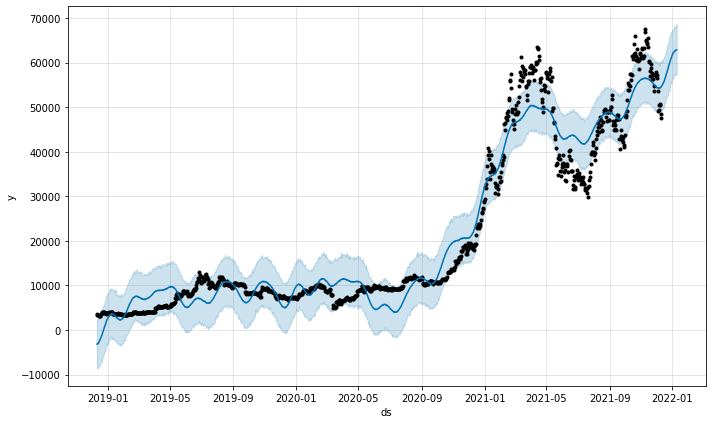

In [53]:
figure=m.plot(forecast, xlabel='ds', ylabel='y')

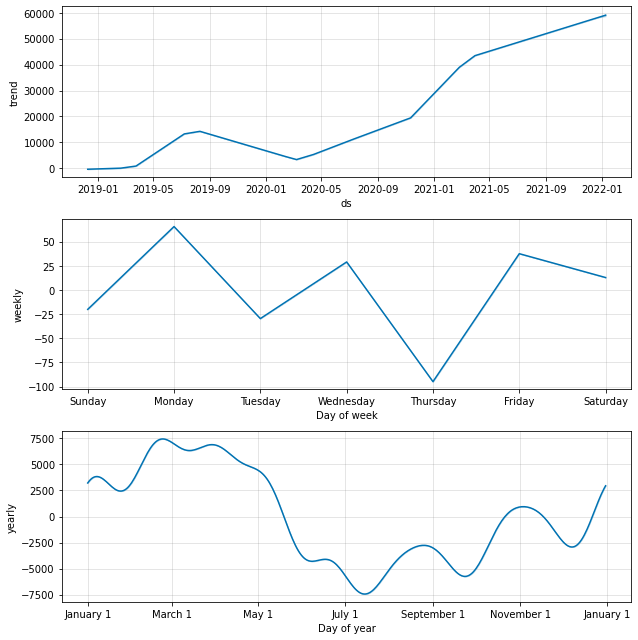

In [54]:
figure2=m.plot_components(forecast)

##Downloading the Forecast data

In [ ]:
from google.colab import files
forecast.to_csv(f'{stock}_forecast.csv')
files.download(f'{stock}_forecast.csv')